# In this notebook we will go through estimating the interaction rate of particles going through a system with and without target in a Bayesian way


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
import corner


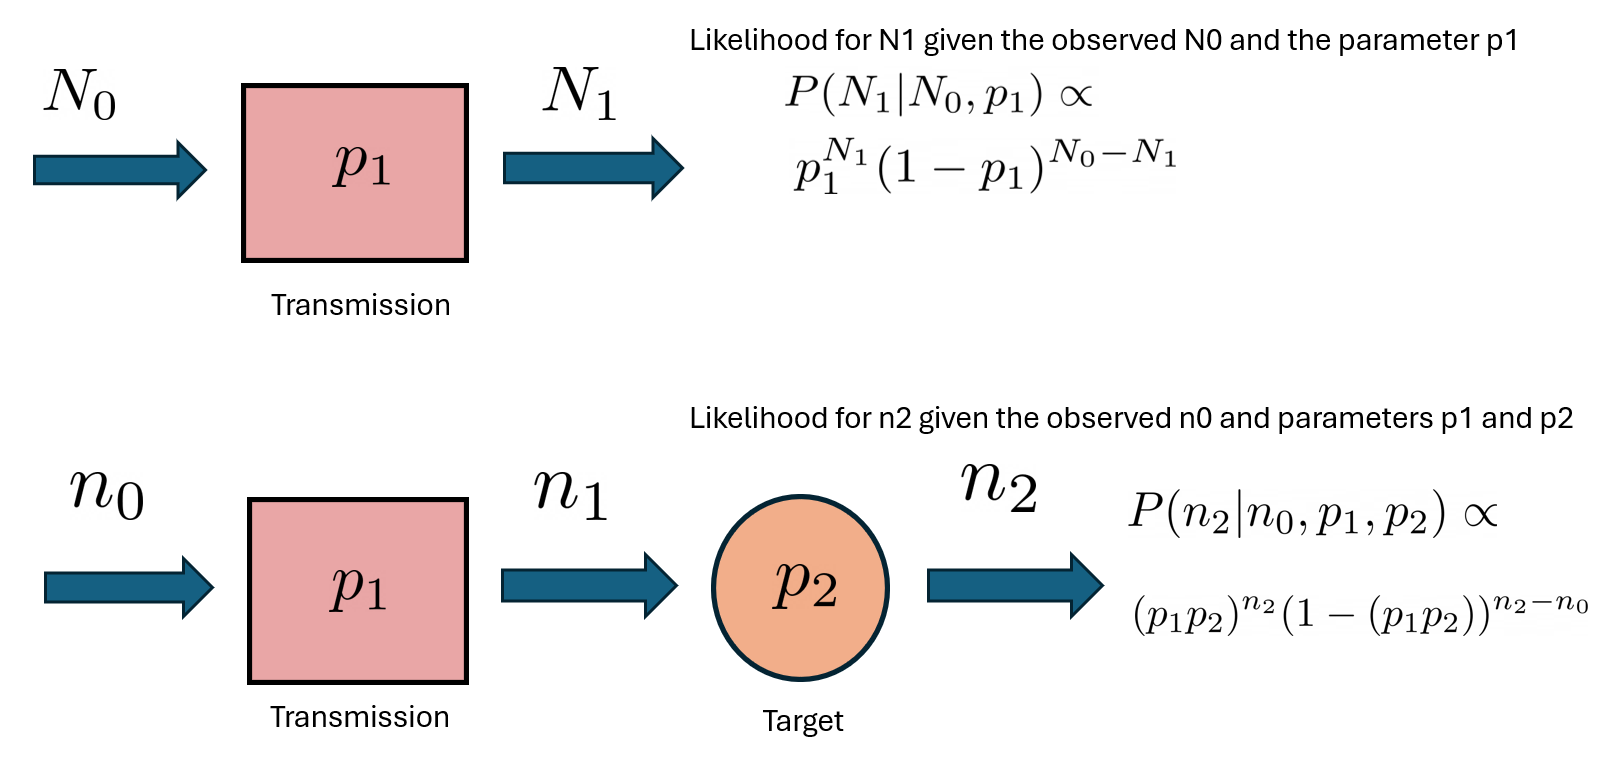

At the end we will like to have a posterior distribution for the unknown parameters given the observed data N0,N1 for the first case without a target, and n0,n2 for the second case with the target. 

This joing posterior distribution will be the multiplication of both likelihoods (times priors if you have priors).

For more details on how the whole Bayesian stuff works (including the Metropolis part) see: https://www.youtube.com/watch?v=YdxzBLkFPJA&list=PLx2qaC0Xa2Rtr_6M6b6Thm7ql3odDzD10&index=2

# Toy situation just to test things out, just focusing on the first scenario without a target (these lines were drafted by chatGPT)

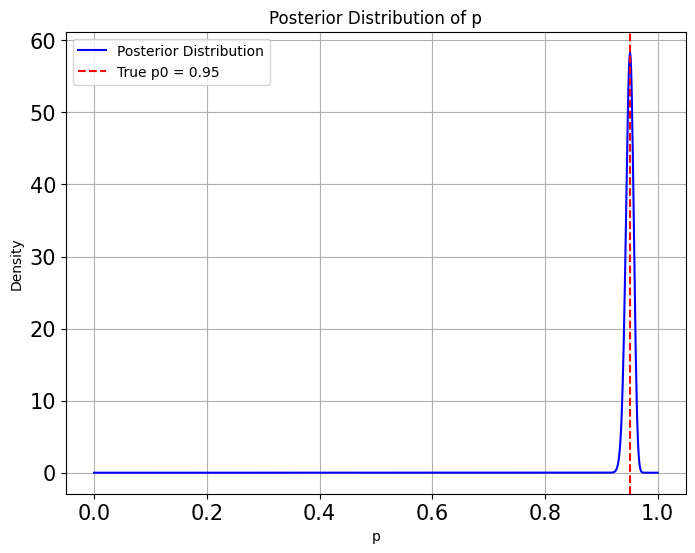

In [73]:
# Parameters
p0 = 0.95  # True probability of success
N = 1000  # Number of trials
alpha_prior = 0  # Prior for successes (for Beta distribution)
beta_prior = 0  # Prior for failures (for Beta distribution)

# Generate pseudo data (successes and failures)
successes = np.random.binomial(1, p0, N)
n_success = np.sum(successes)  # Number of successes
n_failure = N - n_success  # Number of failures

# Posterior parameters for Beta distribution
alpha_post = alpha_prior + n_success
beta_post = beta_prior + n_failure

# Generate values of p for plotting
p_vals_num=1000
p_vals = np.linspace(0, 1, p_vals_num)
posterior = beta.pdf(p_vals, alpha_post, beta_post)

# Plotting the posterior distribution
plt.figure(figsize=(8, 6))
plt.plot(p_vals, posterior, label='Posterior Distribution', color='blue')
plt.axvline(p0, color='red', linestyle='--', label=f'True p0 = {p0}')
plt.title('Posterior Distribution of p')
plt.xlabel('p')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

# The two cases simultaneously

In [62]:
#Data preparation
np.random.seed(42)

#Change these numbers to play with different scenarios
p1_true=0.9
p2_true=0.95

#Guesses for the metropolis algorithm to start
p1_guess=0.8
p2_guess=0.8

#Numbers of incoming particles for both cases
N0=10000
n0=10000


#Process for creating N1
N0_draws = np.random.uniform(0, 1, N0)
N1 = np.sum(N0_draws < p1_true)



#Process for creating n2
n0_draws = np.random.uniform(0, 1, n0)
n1=np.sum(n0_draws < p1_true)

n1_draws = np.random.uniform(0, 1, n1)
n2=np.sum(n1_draws < p2_true)




In [63]:
def log_likelihood(params,data):   
    #We return log-likelihoods because otherwise they will be very tiny numbers (exp^(-7000)). 
    #In the Metropolis algorithm we exponentiate to take the steps
    
    #Be careful, if at some point the parameters start being the numbers observed (in case we want to have uncertainties), then you need
    #to include them in the likelihood through the combinatorial term (k,n)

    
    #Format for data is data=[N,N1,n,n2]
    #format for params is params=[p1,p2]
    N,N1,n,n2=data
    p1,p2=params
    # return (p1**N1*(1-p1)**(N-N1))*((p1*p2)**n2*(1-p1*p2)**(n-n2))
    if p1<0 or p1>1 or p2<0 or p2>1:
        return np.infty
    else:
        return N1*np.log(p1)+(N-N1)*np.log(1-p1)+n2*np.log(p1*p2)+(n-n2)*np.log(1-p1*p2)

In [78]:
# Define the Metropolis algorithm
def metropolis(data,num_iterations, step_size):
#     step_size should be a list the size of the parameters of the model

    initial_parameters=[p1_guess,p2_guess]
    
    cov_step_size=np.diag(step_size)**2

    ################################### Burn part ###################################
    
    burn_samples=1000
    # Set the initial state of the chain
    params_current=initial_parameters
    
    params_list=[]
    posterior_list=[]
    
    log_posterior_current=(log_likelihood(params_current,data))
    
    # Run the Metropolis-Hastings algorithm for burning
    for i in range(burn_samples):
        # Propose a new state for the chain
        params_proposed=np.random.multivariate_normal(params_current,cov_step_size)
        
        log_posterior_proposed=(log_likelihood(params_proposed,data))
        
        # Calculate the acceptance probability
        acceptance_prob = min(1, np.exp(log_posterior_proposed -log_posterior_current))

        # Accept or reject the proposal
        if np.random.uniform() < acceptance_prob:
            params_current = params_proposed
            log_posterior_current=log_posterior_proposed



###################################  After burning ###################################

    acceptance_times=0

    
    for i in range(num_iterations):
        params_proposed=np.random.multivariate_normal(params_current,cov_step_size)
        
        log_posterior_proposed=(log_likelihood(params_proposed,data))
        
        # Calculate the acceptance probability
        acceptance_prob = min(1, np.exp(log_posterior_proposed - log_posterior_current))

        # Accept or reject the proposal
        if np.random.uniform() < acceptance_prob:
            params_current = params_proposed
            log_posterior_current=log_posterior_proposed
            acceptance_times=acceptance_times+1

        # Store the current state
        params_list.append(params_current)
        posterior_list.append(log_posterior_current)
        
    
    #Rule of thumb acceptance is around 30%. 
    #You could plot the accuracy of the estimations as a function of this rate, that would be interesting to see. 
    print("Aceptance Rate:", acceptance_times/num_iterations*100,"%")
    
    return np.array(params_list)

In [80]:
Metropolis_Steps=100000
step_size=[0.005,0.005]
results=metropolis([N0,N1,n0,n2],Metropolis_Steps, step_size)

Aceptance Rate: 37.752 %


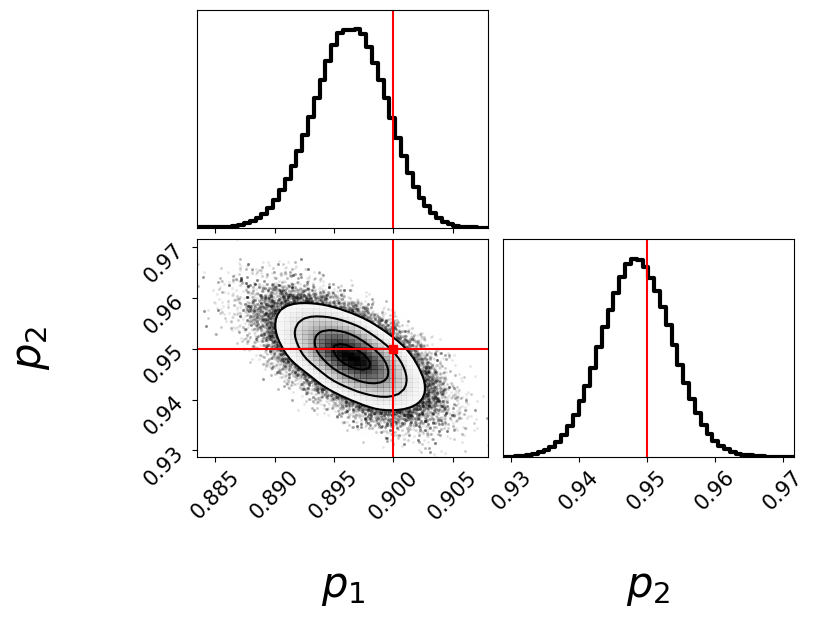

In [76]:
figure = corner.corner(results,
    labels=[r'$p_1$',r'$p_2$'],
    labelpad=0.2,
                       bins=50,
    label_kwargs={"fontsize":30},
                      hist_kwargs= {"linewidth":3},
    quantiles=None
                       ,truths=[p1_true,p2_true], truth_color='r'
                       ,
    smooth=(1.7)
                       ,
    smooth1d=1.0
                      )


width = 8
height = 6
figure.set_size_inches(width, height)
plt.rc('xtick', labelsize=15)    
plt.rc('ytick', labelsize=15)

In red we can see the true value of the two probabilities, which is well covered by the sampling uncertainties